# ISYE 7406 2022 Midterm Election Prediction Project

### Authors: Miguel Asse & Martin Huerta

This dataset will be looking at several sources of data to predict the 2022 Midterm Elections. There will be several sources of data cleaned and used:

## Introduction

1. **Midterm Results** - Historical Midterm results sourced from the [Open Intro Midterms Dataset](https://www.openintro.org/book/statdata/index.php?data=midterms)
1. **Senate Results 1976-2020** - Historical Senate results sourced from [MIT Election Data and Science Lab](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU)
1. **Unemployment Statistics 1951-2021 from the Current Population Survey** - Sourced from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/web/empsit/cpseea01.htm)
1. **Unemployment Statistics for 2022** - Sourced from the [U.S. Bureau of Labor Statistics](https://www.bls.gov/web/empsit/cpseea01.htm)
1. **Historical Educational Achievement from 1940 - Present** - Sourced from [United States Census Bureau](https://www.census.gov/data/tables/time-series/demo/educational-attainment/cps-historical-time-series.html)
1. **2022 Senate Candidates by State and Party** - Sourced from [Ballotpedia](https://ballotpedia.org/United_States_Senate_elections,_2022) with an additional column indicating FiveThirtyEight's predicted winner's from the [FiveThirtyEight Senate Forecast](https://projects.fivethirtyeight.com/2022-election-forecast/senate/?cid=rrpromo)
1. **US Census Bureau's Region and Sub-Region breakdown of the States in the United States** - Sourced from the US Census Bureau website [here](https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf)
1. **Historical data for all races and for Hispanic origin (1610–2020) sourced from Wikipedia** [here](https://en.wikipedia.org/wiki/Historical_racial_and_ethnic_demographics_of_the_United_States#Historical_data_for_all_races_and_for_Hispanic_origin_(1610%E2%80%932020))

Data will be cleaned and the years from 1976 - 2020 will be used to predict the 2022 Midterm Election outcomes using a variety of classification methodds.

In [223]:
# Import necessary packages

import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import chart_studio
from collections import defaultdict
import numpy as np
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly.subplots import make_subplots
import pprint
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statistics import mean
from sklearn.metrics import f1_score

%matplotlib inline
import chart_studio
import chart_studio.plotly as py

# Set Parameters for plot and pandas outputs
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_columns', 30)

In [224]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [225]:
# Read in datasets (note this assumes they are in the same folder as the Jupyter Notebook)

midterms_data = pd.read_csv("midterms_raw.csv")
senate_data = pd.read_csv("senate_data_1976_2020_raw.csv", encoding='utf-8')
unemployment_historical = pd.read_csv("historical_unemployment_averages.csv")
current_unemployment = pd.read_csv("current_year_2022_unemployment_numbers.csv")
senate_candidates_2022_test_set = pd.read_csv("senate_candidates_2022_midterms_test_set.csv")
us_presidents_by_year = pd.read_csv('us_president_by_year.csv')
state_regional_breakdown = pd.read_csv("census_state_regional_breakdown.csv")
census_demographic_breakdown = pd.read_csv("census_demographic_breakdown_1970_to_today.csv")
education_achievement_by_year = pd.read_csv("proportion_of_educational_achievement_by_year.csv")
plotly_api_key = pd.read_csv('plotly_api_key.csv')

# Create 2022 winners due to results being confirmed
senate_winners_2022 = senate_candidates_2022_test_set.copy()
senate_winners_2022['is_actual_winner'] = senate_winners_2022['is_actual_winner'].astype(int)
senate_candidates_2022_test_set.drop('is_actual_winner', axis='columns', inplace=True)

In [226]:
senate_data.head()

year    state state_po  state_fips  state_cen  state_ic     office  \
0  1976  ARIZONA       AZ           4         86        61  US SENATE   
1  1976  ARIZONA       AZ           4         86        61  US SENATE   
2  1976  ARIZONA       AZ           4         86        61  US SENATE   
3  1976  ARIZONA       AZ           4         86        61  US SENATE   
4  1976  ARIZONA       AZ           4         86        61  US SENATE   

    district stage  special            candidate party_detailed  writein  \
0  statewide   gen    False          SAM STEIGER     REPUBLICAN    False   
1  statewide   gen    False  WM. MATHEWS FEIGHAN    INDEPENDENT    False   
2  statewide   gen    False     DENNIS DECONCINI       DEMOCRAT    False   
3  statewide   gen    False        ALLAN NORWITZ    LIBERTARIAN    False   
4  statewide   gen    False            BOB FIELD    INDEPENDENT    False   

    mode  candidatevotes  totalvotes  unofficial   version party_simplified  
0  total          321236      741210       False  20210114       REPUBLICAN  
1  total            1565      741210       False  20210114            OTHER  
2  total          400334      741210       False  20210114         DEMOCRAT  
3  total            7310      741210       False  20210114      LIBERTARIAN  
4  total           10765      741210       False  20210114            OTHER

In [227]:
senate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629 entries, 0 to 3628
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              3629 non-null   int64 
 1   state             3629 non-null   object
 2   state_po          3629 non-null   object
 3   state_fips        3629 non-null   int64 
 4   state_cen         3629 non-null   int64 
 5   state_ic          3629 non-null   int64 
 6   office            3629 non-null   object
 7   district          3629 non-null   object
 8   stage             3629 non-null   object
 9   special           3629 non-null   bool  
 10  candidate         3206 non-null   object
 11  party_detailed    3030 non-null   object
 12  writein           3629 non-null   bool  
 13  mode              3629 non-null   object
 14  candidatevotes    3629 non-null   int64 
 15  totalvotes        3629 non-null   int64 
 16  unofficial        3629 non-null   bool  
 17  version       

In [228]:
senate_data.isnull().sum()

year                  0
state                 0
state_po              0
state_fips            0
state_cen             0
state_ic              0
office                0
district              0
stage                 0
special               0
candidate           423
party_detailed      599
writein               0
mode                  0
candidatevotes        0
totalvotes            0
unofficial            0
version               0
party_simplified      0
dtype: int64

## Data Cleaning

Below, we'll do several iterations of data cleaning and merging to create our training and testing data

In [229]:
# Finalize test Set

# Add regional data to the test set

senate_candidates_2022_test_set = senate_candidates_2022_test_set.merge(state_regional_breakdown, on="state", how="inner")

senate_candidates_2022_test_set.drop(['sub_region'], axis='columns', inplace=True)

senate_candidates_2022_test_set = pd.get_dummies(senate_candidates_2022_test_set, prefix_sep="_", columns=['region'])

# Add educational data to the dataset. Since 2022 data does not currently exist from the Census Bureau,
# we will use 2021 as a proxy.

education_achievement_2022_proxy = education_achievement_by_year.copy()
education_achievement_2022_proxy = education_achievement_2022_proxy[education_achievement_2022_proxy['year'] == 2021]
education_achievement_2022_proxy['year'] = 2022

senate_candidates_2022_test_set = senate_candidates_2022_test_set.merge(education_achievement_2022_proxy, on='year', how='inner')

senate_candidates_2022_test_set.drop(['total'], axis='columns', inplace=True)

senate_candidates_2022_test_set.head()


year    state         candidate     party_detailed party_simplified  \
0  2022  ALABAMA         Will Boyd           DEMOCRAT         DEMOCRAT   
1  2022  ALABAMA       Katie Britt         REPUBLICAN       REPUBLICAN   
2  2022  ALABAMA   John Sophocleus  LIBERTARIAN PARTY            OTHER   
3  2022   ALASKA  Patricia Chesbro           DEMOCRAT         DEMOCRAT   
4  2022   ALASKA       Buzz Kelley         REPUBLICAN       REPUBLICAN   

   number_of_supporting_parties  is_candidate_democrat  \
0                             1                      1   
1                             1                      0   
2                             1                      0   
3                             1                      1   
4                             1                      0   

   is_candidate_republican  is_candidate_other  is_current_president_democrat  \
0                        0                   0                              1   
1                        1                   0                              1   
2                        0                   1                              1   
3                        0                   0                              1   
4                        1                   0                              1   

   is_current_president_republican  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   

   total_unemployed_percentage_of_labor_force  is_predicted_winner_538  \
0                                        3.66                        0   
1                                        3.66                        1   
2                                        3.66                        0   
3                                        3.66                        0   
4                                        3.66                        0   

   region_Midwest  region_Northeast  region_South  region_West  \
0               0                 0             1            0   
1               0                 0             1            0   
2               0                 0             1            0   
3               0                 0             0            1   
4               0                 0             0            1   

   elementary_0_to_4_years  elementary_5_to_8_years  highschool_1_to_3_years  \
0                 0.009235                 0.026102                 0.053959   
1                 0.009235                 0.026102                 0.053959   
2                 0.009235                 0.026102                 0.053959   
3                 0.009235                 0.026102                 0.053959   
4                 0.009235                 0.026102                 0.053959   

   highschool_4_years  college_1_to_3_years  college_4_or_more_years  
0            0.278507              0.253549                 0.378649  
1            0.278507              0.253549                 0.378649  
2            0.278507              0.253549                 0.378649  
3            0.278507              0.253549                 0.378649  
4            0.278507              0.253549                 0.378649

In [230]:
# Remove unnecessary data from various dataframes

# Reduce Historical data to years on or after 1976
midterms_data_clean = midterms_data[midterms_data['year']>=1976]

# Only include general election results for senate data
senate_data_clean = senate_data[senate_data['stage']=='gen']


In [231]:
senate_data_clean['party_simplified'].unique()

array(['REPUBLICAN', 'OTHER', 'DEMOCRAT', 'LIBERTARIAN'], dtype=object)

In [232]:
# Clean up senate data:

# 1. Create percentage_of_vote column and senate_race_key based on year & state
senate_data['percentage_of_vote'] = senate_data['candidatevotes'] / senate_data['totalvotes']

# Fill in missing values
senate_data['candidate'].fillna('No Candidate Listed', inplace=True)
senate_data['party_detailed'].fillna('No Party Detail Available', inplace=True)

senate_data['senate_race_key'] = senate_data['year'].astype(str) + senate_data['state'] + senate_data['candidate']

senate_data_clean = senate_data.copy()

In [233]:
# Remove duplicate winners due to Senate data being by unique by party_detailed column and not candidate

cols = ['senate_race_key', 'year', 'state', 'state_po', 'candidate', 'candidatevotes', 'totalvotes','party_detailed', 'party_simplified']

senate_data_clean_limited = senate_data_clean[cols]
senate_dict = senate_data_clean_limited.to_dict('records')

final_dict = defaultdict(dict)

for item in senate_dict:
    key = item['senate_race_key']
    year = item['year']
    state = item['state']
    state_po = item['state_po']
    candidate = item['candidate']
    votes_won = item['candidatevotes']
    total_votes = item['totalvotes']
    party_detailed = item['party_detailed']
    party_simplified = item['party_simplified']
    if key in final_dict:
        final_dict[key]['year'] = year
        final_dict[key]['state'] = state
        final_dict[key]['candidate'] = candidate
        final_dict[key]['votes_won'] += votes_won
        final_dict[key]['total_votes'] = total_votes
        final_dict[key]['party_detailed'] += "|" + party_detailed
        final_dict[key]['total_votes'] = total_votes
        if final_dict[key]['party_simplified'] != party_simplified and final_dict[key]['party_simplified'].split("|")[-1] != 'OTHER':
            final_dict[key]['party_simplified'] += "|" + party_simplified
        else: pass

    else:
        final_dict[key]['year'] = year
        final_dict[key]['state'] = state
        final_dict[key]['state_po'] = state_po
        final_dict[key]['candidate'] = candidate
        final_dict[key]['votes_won'] = votes_won
        final_dict[key]['total_votes'] = total_votes
        final_dict[key]['party_detailed'] = party_detailed
        final_dict[key]['party_simplified'] = party_simplified
        final_dict[key]['total_votes'] = total_votes


# Create final senate dataframe

senate_data_final = pd.DataFrame.from_dict(data=final_dict, orient="index").reset_index()
senate_data_final.rename(mapper={"index":"senate_race_key"},axis="columns", inplace=True)
senate_data_final["percentage_of_vote"] = senate_data_final["votes_won"] / senate_data_final["total_votes"]



In [234]:
# Determine winners of each race for each year

winners = senate_data_final.loc[senate_data_final.groupby(by=['year','state'])['percentage_of_vote'].idxmax()].reset_index(drop=True)
columns = ['senate_race_key', 'candidate']
winners_final = winners[columns]
winners_final

# Add winner outcome column to senate_data_final

senate_data_merged = senate_data_final.merge(winners_final, on='senate_race_key', how='left', suffixes=[None,"_winner"])
senate_data_final['winner'] = senate_data_final['candidate'] == senate_data_merged['candidate_winner']
senate_data_final['number_of_supporting_parties'] = senate_data_final['party_simplified'].str.split('|').str.len()




In [235]:
## Add is_candidate_democrat, is_candidate_republican, is_candidate_other fields to senate_data_final

senate_data_final["is_candidate_democrat"] = senate_data_final['party_simplified'].str.contains('DEMOCRAT')
senate_data_final["is_candidate_republican"] = senate_data_final['party_simplified'].str.contains('REPUBLICAN')
senate_data_final["is_candidate_other"] = (senate_data_final['party_simplified'].str.contains('OTHER')) & (senate_data_final['number_of_supporting_parties'] == 1)


senate_data_final.head()




senate_race_key  year    state state_po  \
0          1976ARIZONASAM STEIGER  1976  ARIZONA       AZ   
1  1976ARIZONAWM. MATHEWS FEIGHAN  1976  ARIZONA       AZ   
2     1976ARIZONADENNIS DECONCINI  1976  ARIZONA       AZ   
3        1976ARIZONAALLAN NORWITZ  1976  ARIZONA       AZ   
4            1976ARIZONABOB FIELD  1976  ARIZONA       AZ   

             candidate  votes_won  total_votes party_detailed  \
0          SAM STEIGER     321236       741210     REPUBLICAN   
1  WM. MATHEWS FEIGHAN       1565       741210    INDEPENDENT   
2     DENNIS DECONCINI     400334       741210       DEMOCRAT   
3        ALLAN NORWITZ       7310       741210    LIBERTARIAN   
4            BOB FIELD      10765       741210    INDEPENDENT   

  party_simplified  percentage_of_vote  winner  number_of_supporting_parties  \
0       REPUBLICAN            0.433394   False                             1   
1            OTHER            0.002111   False                             1   
2         DEMOCRAT            0.540109    True                             1   
3      LIBERTARIAN            0.009862   False                             1   
4            OTHER            0.014524   False                             1   

   is_candidate_democrat  is_candidate_republican  is_candidate_other  
0                  False                     True               False  
1                  False                    False                True  
2                   True                    False               False  
3                  False                    False               False  
4                  False                    False                True

In [236]:
senate_data_final.merge(midterms_data, how="left", on="year")

senate_data_final.head()

senate_race_key  year    state state_po  \
0          1976ARIZONASAM STEIGER  1976  ARIZONA       AZ   
1  1976ARIZONAWM. MATHEWS FEIGHAN  1976  ARIZONA       AZ   
2     1976ARIZONADENNIS DECONCINI  1976  ARIZONA       AZ   
3        1976ARIZONAALLAN NORWITZ  1976  ARIZONA       AZ   
4            1976ARIZONABOB FIELD  1976  ARIZONA       AZ   

             candidate  votes_won  total_votes party_detailed  \
0          SAM STEIGER     321236       741210     REPUBLICAN   
1  WM. MATHEWS FEIGHAN       1565       741210    INDEPENDENT   
2     DENNIS DECONCINI     400334       741210       DEMOCRAT   
3        ALLAN NORWITZ       7310       741210    LIBERTARIAN   
4            BOB FIELD      10765       741210    INDEPENDENT   

  party_simplified  percentage_of_vote  winner  number_of_supporting_parties  \
0       REPUBLICAN            0.433394   False                             1   
1            OTHER            0.002111   False                             1   
2         DEMOCRAT            0.540109    True                             1   
3      LIBERTARIAN            0.009862   False                             1   
4            OTHER            0.014524   False                             1   

   is_candidate_democrat  is_candidate_republican  is_candidate_other  
0                  False                     True               False  
1                  False                    False                True  
2                   True                    False               False  
3                  False                    False               False  
4                  False                    False                True

In [237]:
# Merge Unemployment data & Senate data

unemployment_by_year = unemployment_historical[['year', 'total_unemployed_percentage_of_labor_force']]

senate_and_unemployment = senate_data_final.merge(unemployment_by_year, how="inner", on="year")

# Change unemployemnt rate to a decimal based percentage

senate_and_unemployment['total_unemployed_percentage_of_labor_force'] = senate_and_unemployment['total_unemployed_percentage_of_labor_force'].apply(lambda x: x/100)

# Add presidental party and boolean columns

senate_unemployment_and_president = senate_and_unemployment.merge(us_presidents_by_year, how='inner', on='year')

senate_unemployment_and_president["is_current_president_democrat"] = senate_unemployment_and_president['presidential_party'].str.contains('Democrat')
senate_unemployment_and_president["is_current_president_republican"] = senate_unemployment_and_president['presidential_party'].str.contains('Republican')

# Merge in state level region and sub region data

senate_unemployment_and_president = senate_unemployment_and_president.merge(state_regional_breakdown, on="state", how="inner")


In [238]:
# Create dummy variables for region and drop sub_region due to collinearity issues

senate_unemployment_and_president = pd.get_dummies(senate_unemployment_and_president, prefix_sep="_", columns=['region'])

senate_unemployment_and_president.drop(['sub_region'],axis="columns", inplace=True)

senate_unemployment_and_president.head()


senate_race_key  year    state state_po  \
0          1976ARIZONASAM STEIGER  1976  ARIZONA       AZ   
1  1976ARIZONAWM. MATHEWS FEIGHAN  1976  ARIZONA       AZ   
2     1976ARIZONADENNIS DECONCINI  1976  ARIZONA       AZ   
3        1976ARIZONAALLAN NORWITZ  1976  ARIZONA       AZ   
4            1976ARIZONABOB FIELD  1976  ARIZONA       AZ   

             candidate  votes_won  total_votes party_detailed  \
0          SAM STEIGER     321236       741210     REPUBLICAN   
1  WM. MATHEWS FEIGHAN       1565       741210    INDEPENDENT   
2     DENNIS DECONCINI     400334       741210       DEMOCRAT   
3        ALLAN NORWITZ       7310       741210    LIBERTARIAN   
4            BOB FIELD      10765       741210    INDEPENDENT   

  party_simplified  percentage_of_vote  winner  number_of_supporting_parties  \
0       REPUBLICAN            0.433394   False                             1   
1            OTHER            0.002111   False                             1   
2         DEMOCRAT            0.540109    True                             1   
3      LIBERTARIAN            0.009862   False                             1   
4            OTHER            0.014524   False                             1   

   is_candidate_democrat  is_candidate_republican  is_candidate_other  \
0                  False                     True               False   
1                  False                    False                True   
2                   True                    False               False   
3                  False                    False               False   
4                  False                    False                True   

   total_unemployed_percentage_of_labor_force president_name  \
0                                       0.077    Gerald Ford   
1                                       0.077    Gerald Ford   
2                                       0.077    Gerald Ford   
3                                       0.077    Gerald Ford   
4                                       0.077    Gerald Ford   

  presidential_party  is_current_president_democrat  \
0         Republican                          False   
1         Republican                          False   
2         Republican                          False   
3         Republican                          False   
4         Republican                          False   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                             True               0                 0   
1                             True               0                 0   
2                             True               0                 0   
3                             True               0                 0   
4                             True               0                 0   

   region_South  region_West  
0             0            1  
1             0            1  
2             0            1  
3             0            1  
4             0            1

In [239]:
# Bring in white population and non-white population statistics by year into dataset

white_vs_non_white_census = census_demographic_breakdown[['year', 'white_population_proportion', 'non_white_population_proportion']]

senate_unemployment_and_president = senate_unemployment_and_president.merge(white_vs_non_white_census, on="year", how="inner")

senate_unemployment_and_president.head()


senate_race_key  year    state state_po  \
0          1976ARIZONASAM STEIGER  1976  ARIZONA       AZ   
1  1976ARIZONAWM. MATHEWS FEIGHAN  1976  ARIZONA       AZ   
2     1976ARIZONADENNIS DECONCINI  1976  ARIZONA       AZ   
3        1976ARIZONAALLAN NORWITZ  1976  ARIZONA       AZ   
4            1976ARIZONABOB FIELD  1976  ARIZONA       AZ   

             candidate  votes_won  total_votes party_detailed  \
0          SAM STEIGER     321236       741210     REPUBLICAN   
1  WM. MATHEWS FEIGHAN       1565       741210    INDEPENDENT   
2     DENNIS DECONCINI     400334       741210       DEMOCRAT   
3        ALLAN NORWITZ       7310       741210    LIBERTARIAN   
4            BOB FIELD      10765       741210    INDEPENDENT   

  party_simplified  percentage_of_vote  winner  number_of_supporting_parties  \
0       REPUBLICAN            0.433394   False                             1   
1            OTHER            0.002111   False                             1   
2         DEMOCRAT            0.540109    True                             1   
3      LIBERTARIAN            0.009862   False                             1   
4            OTHER            0.014524   False                             1   

   is_candidate_democrat  is_candidate_republican  is_candidate_other  \
0                  False                     True               False   
1                  False                    False                True   
2                   True                    False               False   
3                  False                    False               False   
4                  False                    False                True   

   total_unemployed_percentage_of_labor_force president_name  \
0                                       0.077    Gerald Ford   
1                                       0.077    Gerald Ford   
2                                       0.077    Gerald Ford   
3                                       0.077    Gerald Ford   
4                                       0.077    Gerald Ford   

  presidential_party  is_current_president_democrat  \
0         Republican                          False   
1         Republican                          False   
2         Republican                          False   
3         Republican                          False   
4         Republican                          False   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                             True               0                 0   
1                             True               0                 0   
2                             True               0                 0   
3                             True               0                 0   
4                             True               0                 0   

   region_South  region_West  white_population_proportion  \
0             0            1                     0.876527   
1             0            1                     0.876527   
2             0            1                     0.876527   
3             0            1                     0.876527   
4             0            1                     0.876527   

   non_white_population_proportion  
0                         0.123473  
1                         0.123473  
2                         0.123473  
3                         0.123473  
4                         0.123473

In [240]:
# Add educational achievement data by year for adults aged 25+

senate_unemployment_and_president = senate_unemployment_and_president.merge(education_achievement_by_year, on='year', how='inner')

senate_unemployment_and_president.drop('total', axis="columns", inplace=True)

senate_unemployment_and_president.head()

senate_race_key  year    state state_po  \
0          1976ARIZONASAM STEIGER  1976  ARIZONA       AZ   
1  1976ARIZONAWM. MATHEWS FEIGHAN  1976  ARIZONA       AZ   
2     1976ARIZONADENNIS DECONCINI  1976  ARIZONA       AZ   
3        1976ARIZONAALLAN NORWITZ  1976  ARIZONA       AZ   
4            1976ARIZONABOB FIELD  1976  ARIZONA       AZ   

             candidate  votes_won  total_votes party_detailed  \
0          SAM STEIGER     321236       741210     REPUBLICAN   
1  WM. MATHEWS FEIGHAN       1565       741210    INDEPENDENT   
2     DENNIS DECONCINI     400334       741210       DEMOCRAT   
3        ALLAN NORWITZ       7310       741210    LIBERTARIAN   
4            BOB FIELD      10765       741210    INDEPENDENT   

  party_simplified  percentage_of_vote  winner  number_of_supporting_parties  \
0       REPUBLICAN            0.433394   False                             1   
1            OTHER            0.002111   False                             1   
2         DEMOCRAT            0.540109    True                             1   
3      LIBERTARIAN            0.009862   False                             1   
4            OTHER            0.014524   False                             1   

   is_candidate_democrat  is_candidate_republican  is_candidate_other  ...  \
0                  False                     True               False  ...   
1                  False                    False                True  ...   
2                   True                    False               False  ...   
3                  False                    False               False  ...   
4                  False                    False                True  ...   

   presidential_party is_current_president_democrat  \
0          Republican                         False   
1          Republican                         False   
2          Republican                         False   
3          Republican                         False   
4          Republican                         False   

  is_current_president_republican  region_Midwest  region_Northeast  \
0                            True               0                 0   
1                            True               0                 0   
2                            True               0                 0   
3                            True               0                 0   
4                            True               0                 0   

   region_South  region_West  white_population_proportion  \
0             0            1                     0.876527   
1             0            1                     0.876527   
2             0            1                     0.876527   
3             0            1                     0.876527   
4             0            1                     0.876527   

   non_white_population_proportion  elementary_0_to_4_years  \
0                         0.123473                 0.038713   
1                         0.123473                 0.038713   
2                         0.123473                 0.038713   
3                         0.123473                 0.038713   
4                         0.123473                 0.038713   

   elementary_5_to_8_years  highschool_1_to_3_years  highschool_4_years  \
0                 0.167542                  0.15317            0.363128   
1                 0.167542                  0.15317            0.363128   
2                 0.167542                  0.15317            0.363128   
3                 0.167542                  0.15317            0.363128   
4                 0.167542                  0.15317            0.363128   

   college_1_to_3_years  college_4_or_more_years  
0              0.130225                 0.147213  
1              0.130225                 0.147213  
2              0.130225                 0.147213  
3              0.130225                 0.147213  
4              0.130225                 0.147213  

[5 rows x 32 columns]

In [241]:
# Create training dataset

training_data = senate_unemployment_and_president.copy()

training_data['is_candidate_democrat'] = training_data['is_candidate_democrat'].apply(lambda x: 1 if x == True else 0)
training_data['is_candidate_republican'] = training_data['is_candidate_republican'].apply(lambda x: 1 if x == True else 0)
training_data['is_candidate_other'] = training_data['is_candidate_other'].apply(lambda x: 1 if x == True else 0)
training_data['is_current_president_democrat'] = training_data['is_current_president_democrat'].apply(lambda x: 1 if x == True else 0)
training_data['is_current_president_republican'] = training_data['is_current_president_republican'].apply(lambda x: 1 if x == True else 0)

training_data['IsCandidateWinner'] = np.where(training_data['winner']==True, 1, 0)

# Drop unnecessary values from training dataset

training_data.drop(['winner', 'senate_race_key', 'state_po', 'year', 'state', 'candidate',
                    'votes_won', 'total_votes', 'party_detailed', 'party_simplified', 'percentage_of_vote',
                    'president_name', 'presidential_party'], axis=1, inplace=True)

training_data.head()


number_of_supporting_parties  is_candidate_democrat  \
0                             1                      0   
1                             1                      0   
2                             1                      1   
3                             1                      0   
4                             1                      0   

   is_candidate_republican  is_candidate_other  \
0                        1                   0   
1                        0                   1   
2                        0                   0   
3                        0                   0   
4                        0                   1   

   total_unemployed_percentage_of_labor_force  is_current_president_democrat  \
0                                       0.077                              0   
1                                       0.077                              0   
2                                       0.077                              0   
3                                       0.077                              0   
4                                       0.077                              0   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                                1               0                 0   
1                                1               0                 0   
2                                1               0                 0   
3                                1               0                 0   
4                                1               0                 0   

   region_South  region_West  white_population_proportion  \
0             0            1                     0.876527   
1             0            1                     0.876527   
2             0            1                     0.876527   
3             0            1                     0.876527   
4             0            1                     0.876527   

   non_white_population_proportion  elementary_0_to_4_years  \
0                         0.123473                 0.038713   
1                         0.123473                 0.038713   
2                         0.123473                 0.038713   
3                         0.123473                 0.038713   
4                         0.123473                 0.038713   

   elementary_5_to_8_years  highschool_1_to_3_years  highschool_4_years  \
0                 0.167542                  0.15317            0.363128   
1                 0.167542                  0.15317            0.363128   
2                 0.167542                  0.15317            0.363128   
3                 0.167542                  0.15317            0.363128   
4                 0.167542                  0.15317            0.363128   

   college_1_to_3_years  college_4_or_more_years  IsCandidateWinner  
0              0.130225                 0.147213                  0  
1              0.130225                 0.147213                  0  
2              0.130225                 0.147213                  1  
3              0.130225                 0.147213                  0  
4              0.130225                 0.147213                  0

In [242]:
# Add white population and non-white population statistics by year into testing dataset

candidates_2022 = senate_candidates_2022_test_set['candidate']
state_2022 = senate_candidates_2022_test_set['state']
predicted_winner_2022 = senate_candidates_2022_test_set['is_predicted_winner_538']

senate_candidates_2022_test_set = senate_candidates_2022_test_set.merge(white_vs_non_white_census, on="year", how="inner")

senate_candidates_2022_test_set.drop(['party_simplified',
 'year',
 'party_detailed',
 'candidate',
 'is_predicted_winner_538',
 'state'], axis=1, inplace=True)

X = training_data.drop('IsCandidateWinner', axis = 1)
train_cols = X.columns
senate_candidates_2022_test_set = senate_candidates_2022_test_set[train_cols]
senate_candidates_2022_test_set.head()

number_of_supporting_parties  is_candidate_democrat  \
0                             1                      1   
1                             1                      0   
2                             1                      0   
3                             1                      1   
4                             1                      0   

   is_candidate_republican  is_candidate_other  \
0                        0                   0   
1                        1                   0   
2                        0                   1   
3                        0                   0   
4                        1                   0   

   total_unemployed_percentage_of_labor_force  is_current_president_democrat  \
0                                        3.66                              1   
1                                        3.66                              1   
2                                        3.66                              1   
3                                        3.66                              1   
4                                        3.66                              1   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                                0               0                 0   
1                                0               0                 0   
2                                0               0                 0   
3                                0               0                 0   
4                                0               0                 0   

   region_South  region_West  white_population_proportion  \
0             1            0                     0.616315   
1             1            0                     0.616315   
2             1            0                     0.616315   
3             0            1                     0.616315   
4             0            1                     0.616315   

   non_white_population_proportion  elementary_0_to_4_years  \
0                         0.383685                 0.009235   
1                         0.383685                 0.009235   
2                         0.383685                 0.009235   
3                         0.383685                 0.009235   
4                         0.383685                 0.009235   

   elementary_5_to_8_years  highschool_1_to_3_years  highschool_4_years  \
0                 0.026102                 0.053959            0.278507   
1                 0.026102                 0.053959            0.278507   
2                 0.026102                 0.053959            0.278507   
3                 0.026102                 0.053959            0.278507   
4                 0.026102                 0.053959            0.278507   

   college_1_to_3_years  college_4_or_more_years  
0              0.253549                 0.378649  
1              0.253549                 0.378649  
2              0.253549                 0.378649  
3              0.253549                 0.378649  
4              0.253549                 0.378649

## Exploratory Data Analysis

As part of the exploratory data analysis of the project we're going to:

1. Visualize the Senate Map visually usig Plotly Expres

In [243]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3436 entries, 0 to 3435
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   number_of_supporting_parties                3436 non-null   int64  
 1   is_candidate_democrat                       3436 non-null   int64  
 2   is_candidate_republican                     3436 non-null   int64  
 3   is_candidate_other                          3436 non-null   int64  
 4   total_unemployed_percentage_of_labor_force  3436 non-null   float64
 5   is_current_president_democrat               3436 non-null   int64  
 6   is_current_president_republican             3436 non-null   int64  
 7   region_Midwest                              3436 non-null   uint8  
 8   region_Northeast                            3436 non-null   uint8  
 9   region_South                                3436 non-null   uint8  
 10  region_West 

In [244]:
training_data.describe()

number_of_supporting_parties  is_candidate_democrat  \
count                   3436.000000            3436.000000   
mean                       1.004075               0.231374   
std                        0.063711               0.421772   
min                        1.000000               0.000000   
25%                        1.000000               0.000000   
50%                        1.000000               0.000000   
75%                        1.000000               0.000000   
max                        2.000000               1.000000   

       is_candidate_republican  is_candidate_other  \
count              3436.000000         3436.000000   
mean                  0.230501            0.433062   
std                   0.421215            0.495571   
min                   0.000000            0.000000   
25%                   0.000000            0.000000   
50%                   0.000000            0.000000   
75%                   0.000000            1.000000   
max                   1.000000            1.000000   

       total_unemployed_percentage_of_labor_force  \
count                                 3436.000000   
mean                                     0.063673   
std                                      0.016269   
min                                      0.039000   
25%                                      0.054000   
50%                                      0.061000   
75%                                      0.075000   
max                                      0.097000   

       is_current_president_democrat  is_current_president_republican  \
count                    3436.000000                      3436.000000   
mean                        0.414435                         0.585565   
std                         0.492696                         0.492696   
min                         0.000000                         0.000000   
25%                         0.000000                         0.000000   
50%                         0.000000                         1.000000   
75%                         1.000000                         1.000000   
max                         1.000000                         1.000000   

       region_Midwest  region_Northeast  region_South  region_West  \
count     3436.000000       3436.000000   3436.000000  3436.000000   
mean         0.242142          0.202561      0.306461     0.248836   
std          0.428442          0.401967      0.461091     0.432401   
min          0.000000          0.000000      0.000000     0.000000   
25%          0.000000          0.000000      0.000000     0.000000   
50%          0.000000          0.000000      0.000000     0.000000   
75%          0.000000          0.000000      1.000000     0.000000   
max          1.000000          1.000000      1.000000     1.000000   

       white_population_proportion  non_white_population_proportion  \
count                  3436.000000                      3436.000000   
mean                      0.771122                         0.228878   
std                       0.062032                         0.062032   
min                       0.616315                         0.123473   
25%                       0.724070                         0.168505   
50%                       0.751401                         0.248599   
75%                       0.831495                         0.275930   
max                       0.876527                         0.383685   

       elementary_0_to_4_years  elementary_5_to_8_years  \
count              3436.000000              3436.000000   
mean                  0.019039                 0.069533   
std                   0.008337                 0.040903   
min                   0.009235                 0.025948   
25%                   0.012142                 0.038127   
50%                   0.015933                 0.053861   
75%                   0.024493                 0.095954   
max                   0.038713                 0.167542   

       highschool_1_to

In [245]:
training_data.isnull().sum()

number_of_supporting_parties                  0
is_candidate_democrat                         0
is_candidate_republican                       0
is_candidate_other                            0
total_unemployed_percentage_of_labor_force    0
is_current_president_democrat                 0
is_current_president_republican               0
region_Midwest                                0
region_Northeast                              0
region_South                                  0
region_West                                   0
white_population_proportion                   0
non_white_population_proportion               0
elementary_0_to_4_years                       0
elementary_5_to_8_years                       0
highschool_1_to_3_years                       0
highschool_4_years                            0
college_1_to_3_years                          0
college_4_or_more_years                       0
IsCandidateWinner                             0
dtype: int64

In [288]:
us_senate_winners_map = px.choropleth(
    data_frame=winners,
    locations='state_po',
    locationmode='USA-states',
    color='party_simplified',
    animation_frame='year',
    hover_name='state_po',
    color_discrete_map={'DEMOCRAT': 'BLUE', 'REPUBLICAN': 'RED', 'OTHER': 'GREEN'},
    scope='usa',
    labels={'party_simplified': 'Political Party'},
    title="Senate Winners Over Time"
)

# us_senate_winners_map

In [247]:
# Export Plotly chart to Chart Studio

chart_studio.tools.set_credentials_file(username='gatormig', api_key=plotly_api_key.iloc[0]['api_key'])
py.plot(us_senate_winners_map, filename = 'us_senate_winners_map_over_time', auto_open=False)

'https://plotly.com/~gatormig/36/'

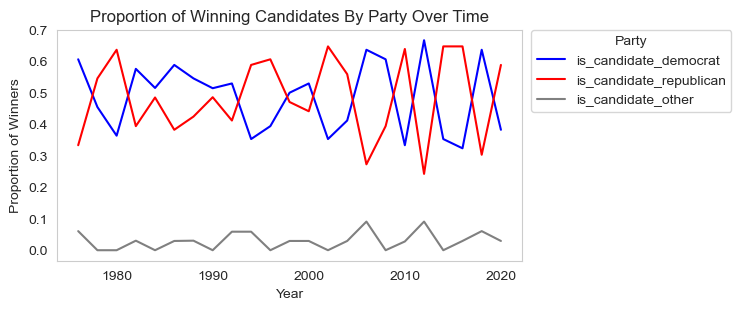

In [248]:
# See of winning party members over time
f,ax_line = plt.subplots(1,1,figsize=(6,3))

winners = senate_unemployment_and_president[(senate_unemployment_and_president['winner']==True)]
winning_parties = winners[['year', 'is_candidate_democrat', 'is_candidate_republican', 'is_candidate_other']]
winners_over_time = winning_parties.groupby('year', as_index=False).mean()

# Remove last row as that was a special election with only 2 seats in January
winners_over_time.drop(winners_over_time.tail(1).index,inplace=True) 

# Create winners over time chart
winners_chart = sns.lineplot(x='year', y='value', hue='variable', 
                            data=pd.melt(winners_over_time, ['year']),
                            palette=dict(is_candidate_democrat="#0000FF", is_candidate_republican="#FF0000", is_candidate_other="#808080"),
                            ax=ax_line)
plt.legend(title='Party', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
winners_chart.set_title('Proportion of Winning Candidates By Party Over Time')
winners_chart.set_xlabel('Year')
winners_chart.set_ylabel('Proportion of Winners')
plt.grid(None)
plt.show()

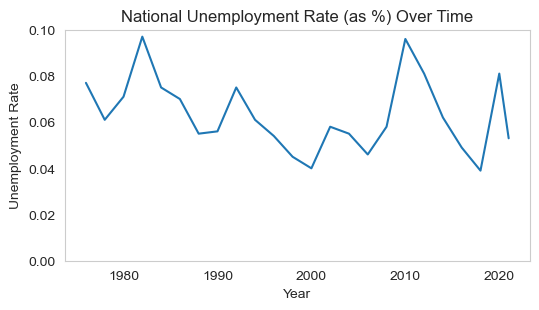

In [249]:
# See unemployment rate over time
f,ax_line = plt.subplots(1,1,figsize=(6,3))

unique_unemployment_by_year = winners[['year', 'total_unemployed_percentage_of_labor_force']]
unemployment_by_year = unique_unemployment_by_year.groupby('year', as_index=False).mean()#

# Create winners over time chart
unemployment_chart = sns.lineplot(
    x='year', y='value', 
    data=pd.melt(unemployment_by_year,['year']),
    ax=ax_line)
unemployment_chart.set_title('National Unemployment Rate (as %) Over Time')
unemployment_chart.set_xlabel('Year')
unemployment_chart.set_ylabel('Unemployment Rate')
unemployment_chart.set_ylim(0, 0.10)
plt.grid(None)
plt.show()

In [250]:
#sns.pairplot(senate_unemployment_and_president, hue = 'winner', palette = 'Set1')

#plt.show()

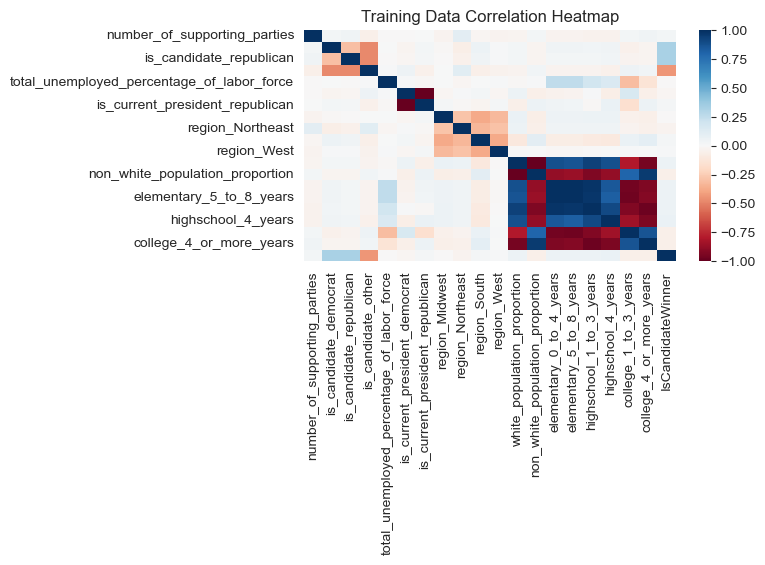

In [251]:
f,ax_line = plt.subplots(1,1,figsize=(6,3))
training_correlation = training_data.corr()
corr_chart = sns.heatmap(
    data=training_correlation,
    vmin=-1,
    vmax=1,
    annot=False,
    cmap='RdBu', 
    fmt='.1f',
    ax=ax_line)
corr_chart.set_title("Training Data Correlation Heatmap")
plt.show()

In [252]:
# Determine the proportion of winners versus candidates over time to determine class balance for classifiers

rate_over_winners_over_time = senate_unemployment_and_president.groupby('year')['winner'].agg(
    total_winners='sum', 
    total_candidates='count').reset_index()

rate_over_winners_over_time['proportion_of_winners_vs_candidates'] = rate_over_winners_over_time['total_winners'] / rate_over_winners_over_time['total_candidates']

print("The average rate of winners vs candidates over time is: ", str(rate_over_winners_over_time['proportion_of_winners_vs_candidates'].mean()))


The average rate of winners vs candidates over time is:  0.23289026055287665


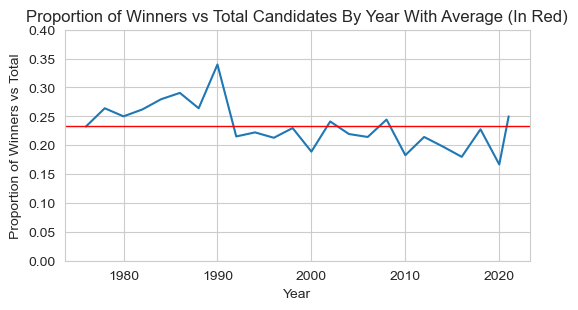

In [253]:
f,ax_line = plt.subplots(1,1,figsize=(6,3))

winners_vs_losers_chart = sns.lineplot(
    data=rate_over_winners_over_time,
    x='year',
    y='proportion_of_winners_vs_candidates',
    ax=ax_line
)
winners_vs_losers_chart.axhline(
    rate_over_winners_over_time['proportion_of_winners_vs_candidates'].mean(),
    color='red',
    lw=1)

plt.title("Proportion of Winners vs Total Candidates By Year With Average (In Red)")
plt.xlabel("Year")
plt.ylabel("Proportion of Winners vs Total")
plt.ylim(0, 0.40)
plt.show()

## Methodology

## Logistic Regression

In [254]:
#Train-Test Split using 20% Test

In [255]:
X = training_data.drop('IsCandidateWinner', axis = 1)
y = training_data['IsCandidateWinner']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=101)

In [256]:
#Import Logistic Regression
from sklearn.linear_model import LogisticRegression

#Fitting Model
logistic_model = LogisticRegression(class_weight='balanced', random_state=123)
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=123)

In [257]:
#Predictions
log_pred = logistic_model.predict(X_test)

Mean Error Rate is:  0.2601744186046512 

The F1 Score is:  0.6247379454926625 



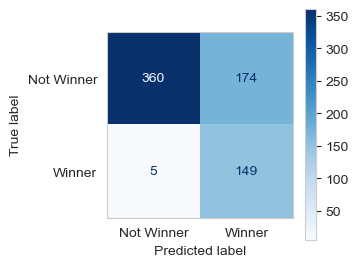

In [258]:
#Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

print("Mean Error Rate is: ", str(mean(log_pred != y_test)), "\n")
print("The F1 Score is: ", f1_score(y_test, log_pred), "\n")
cm_display_lr = ConfusionMatrixDisplay.from_predictions(y_test, log_pred, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)



## Decision Trees

In [259]:
#Fitting the model
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight='balanced', random_state=123)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=123)

In [260]:
#Model Evaluation
dt_pred = dt.predict(X_test)

Mean Error Rate is:  0.22674418604651161 

The F1 Score is:  0.6303317535545023 



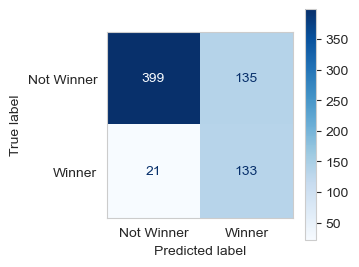

In [261]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))
print("Mean Error Rate is: ", str(mean(dt_pred != y_test)), "\n")
print("The F1 Score is: ", f1_score(y_test, dt_pred), "\n")
cm_display_dt = ConfusionMatrixDisplay.from_predictions(y_test, dt_pred, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

In [262]:
#Tree Visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydot

features = list(training_data.columns[1:])
features

['is_candidate_democrat',
 'is_candidate_republican',
 'is_candidate_other',
 'total_unemployed_percentage_of_labor_force',
 'is_current_president_democrat',
 'is_current_president_republican',
 'region_Midwest',
 'region_Northeast',
 'region_South',
 'region_West',
 'white_population_proportion',
 'non_white_population_proportion',
 'elementary_0_to_4_years',
 'elementary_5_to_8_years',
 'highschool_1_to_3_years',
 'highschool_4_years',
 'college_1_to_3_years',
 'college_4_or_more_years',
 'IsCandidateWinner']

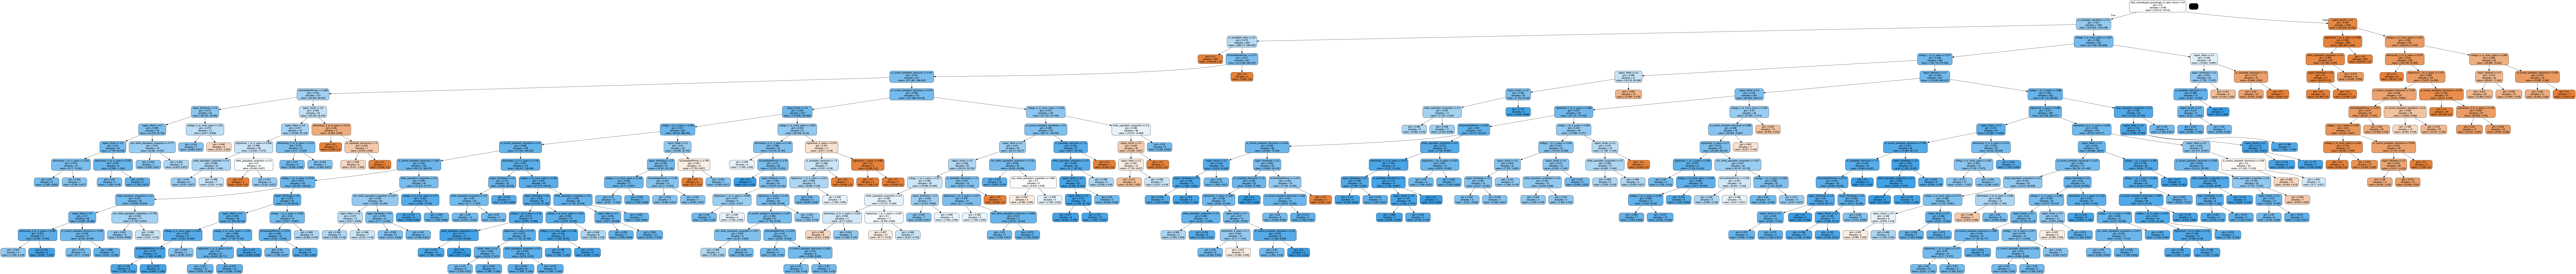

In [263]:
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
dt_graph = Image(graph[0].create_png())

dt_graph

## Random Forests

In [264]:
#Fitting the model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=123)

In [265]:
#Model Evaluation
rf_pred = rf.predict(X_test)

Mean Error Rate is:  0.22819767441860464 

The F1 Score is:  0.6123456790123457 



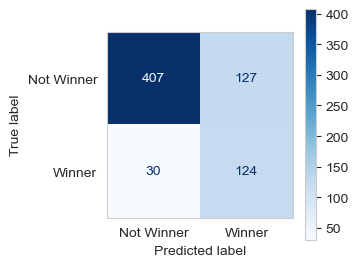

In [266]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

print("Mean Error Rate is: ", str(mean(rf_pred != y_test)), "\n")
print("The F1 Score is: ", f1_score(y_test, rf_pred), "\n")
cm_display_rf = ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

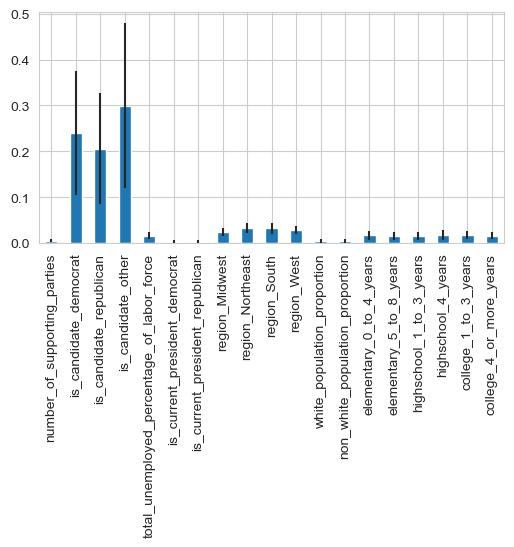

In [267]:
from sklearn.inspection import permutation_importance

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, fi_ax = plt.subplots(1,1,figsize=(6,3))

forest_importances.plot.bar(yerr=std, ax=fi_ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

## KNN

## Standardize the Variables

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale.

In [268]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(training_data.drop('IsCandidateWinner',axis=1))

StandardScaler()

In [269]:
scaled_features = scaler.transform(training_data.drop('IsCandidateWinner',axis=1))

In [270]:
df_feat = pd.DataFrame(scaled_features,columns=training_data.columns[:-1])
df_feat.head()

number_of_supporting_parties  is_candidate_democrat  \
0                     -0.063962              -0.548655   
1                     -0.063962              -0.548655   
2                     -0.063962               1.822639   
3                     -0.063962              -0.548655   
4                     -0.063962              -0.548655   

   is_candidate_republican  is_candidate_other  \
0                 1.827124           -0.873991   
1                -0.547308            1.144176   
2                -0.547308           -0.873991   
3                -0.547308           -0.873991   
4                -0.547308            1.144176   

   total_unemployed_percentage_of_labor_force  is_current_president_democrat  \
0                                    0.819313                      -0.841281   
1                                    0.819313                      -0.841281   
2                                    0.819313                      -0.841281   
3                                    0.819313                      -0.841281   
4                                    0.819313                      -0.841281   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                         0.841281       -0.565251         -0.503999   
1                         0.841281       -0.565251         -0.503999   
2                         0.841281       -0.565251         -0.503999   
3                         0.841281       -0.565251         -0.503999   
4                         0.841281       -0.565251         -0.503999   

   region_South  region_West  white_population_proportion  \
0     -0.664741     1.737445                     1.699446   
1     -0.664741     1.737445                     1.699446   
2     -0.664741     1.737445                     1.699446   
3     -0.664741     1.737445                     1.699446   
4     -0.664741     1.737445                     1.699446   

   non_white_population_proportion  elementary_0_to_4_years  \
0                        -1.699446                 2.360346   
1                        -1.699446                 2.360346   
2                        -1.699446                 2.360346   
3                        -1.699446                 2.360346   
4                        -1.699446                 2.360346   

   elementary_5_to_8_years  highschool_1_to_3_years  highschool_4_years  \
0                 2.396446                 2.090497            0.896034   
1                 2.396446                 2.090497            0.896034   
2                 2.396446                 2.090497            0.896034   
3                 2.396446                 2.090497            0.896034   
4                 2.396446                 2.090497            0.896034   

   college_1_to_3_years  college_4_or_more_years  
0             -2.046024                -1.717531  
1             -2.046024                -1.717531  
2             -2.046024                -1.717531  
3             -2.046024                -1.717531  
4             -2.046024                -1.717531

In [271]:
from sklearn.model_selection import train_test_split

In [272]:
X_traink, X_testk, y_traink, y_testk = train_test_split(scaled_features, training_data['IsCandidateWinner'],
                                                    test_size=0.20, random_state = 123)

In [273]:
#Using KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_traink,y_traink)

KNeighborsClassifier(n_neighbors=1)

In [274]:
predk = knn.predict(X_testk)

Mean Error Rate is:  0.313953488372093 

The F1 Score is:  0.25517241379310346 



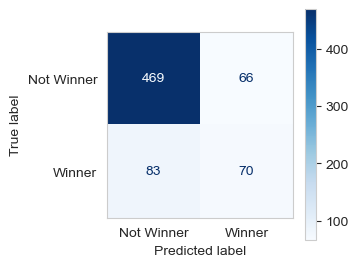

In [275]:
#Evaluation
f,cm_ax = plt.subplots(1,1,figsize=(3,3))
from sklearn.metrics import classification_report,confusion_matrix

print("Mean Error Rate is: ", str(mean(predk != y_test)), "\n")
print("The F1 Score is: ", f1_score(y_test, predk), "\n")
cm_display_knn1 = ConfusionMatrixDisplay.from_predictions(y_testk, predk, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

In [276]:
#Choosing a K value
n_neighbors = []
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_traink,y_traink)
    pred_i = knn.predict(X_testk)
    n_neighbors.append(i)
    error_rate.append(np.mean(pred_i != y_testk))
    
knn_error_rates = list(zip(n_neighbors, error_rate))

knn_error_df = pd.DataFrame(knn_error_rates, columns = ['Neighbors', 'Error Rate'])

knn_error_df.head()

Neighbors  Error Rate
0          1    0.216570
1          2    0.212209
2          3    0.223837
3          4    0.232558
4          5    0.239826

## KNN Grid Search

Below we'll use KNN Grid Search to find the best algorithm for the KNN model for our data based on a variety of parameters

### Note - Code commented out below for time-running purposes both the algorithm found the following was optimal:

* **algorithm** - 'kd_tree'
* **leaf_size** - 3
* **metric** - 'euclidean'
* **n_neighbors** - 9


In [277]:
#knn_grid = KNeighborsClassifier()
#k_range = list(range(2, 40))
#leaf_size = list(range(2, 50))

#parameter_grid = {
#    'n_neighbors': k_range,
#    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#    'leaf_size': leaf_size,
#    'metric': ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan'],
#}



#grid_search = GridSearchCV(estimator = knn_grid, param_grid = parameter_grid, cv = 10, n_jobs = -1, verbose = 1, scoring='f1')

#grid_search.fit(X_traink, y_traink)

# Display the best parameters based on the GridSearchCV
#print(grid_search.best_params_)


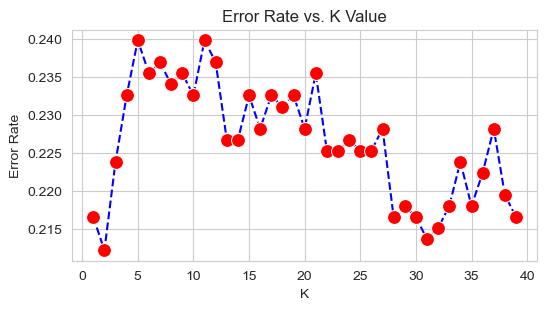

In [278]:
plt.figure(figsize=(6,3))
sns.lineplot(data= knn_error_df, x='Neighbors', y='Error Rate', color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

The Minimum K-Value is:  2 

Mean Error Rate is:  0.21220930232558138 

The F1 Score is:  0.3363636363636363 



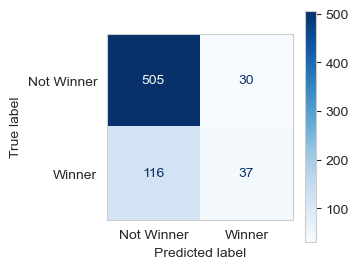

In [279]:
# Find minimum K-Value where Neighbors > 1
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

minimum_k = int(knn_error_df.iloc[knn_error_df[knn_error_df['Neighbors'] > 1]['Error Rate'].idxmin()]['Neighbors'])

print("The Minimum K-Value is: ", minimum_k, "\n")

knn = KNeighborsClassifier(n_neighbors=minimum_k)

knn.fit(X_traink,y_traink)
pred = knn.predict(X_testk)

print("Mean Error Rate is: ", str(mean(pred != y_testk)), "\n")
print("The F1 Score is: ", f1_score(y_testk, pred), "\n")
cm_display_knn = ConfusionMatrixDisplay.from_predictions(y_testk, pred, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

## KNN Grid Search Output

We'll run the KNN Code as well with our GridSearch Values to evaluate performance against the test set

The Grid Search KNN output is below: 

Mean Error Rate is:  0.22819767441860464 

The F1 Score is:  0.4852459016393443 



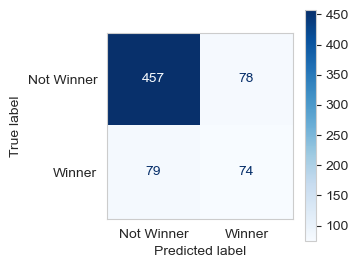

In [280]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

knn_grid = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree', leaf_size=3, metric='euclidean')

knn_grid.fit(X_traink,y_traink)
pred_grid = knn_grid.predict(X_testk)

print("The Grid Search KNN output is below: \n")

print("Mean Error Rate is: ", str(mean(pred_grid != y_testk)), "\n")
print("The F1 Score is: ", f1_score(y_testk, pred_grid), "\n")
cm_display_knn_grid = ConfusionMatrixDisplay.from_predictions(y_testk, pred_grid, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

## Boosting - AdaBoostClassifier

Mean Error Rate is:  0.24709302325581395 

The F1 Score is:  0.24778761061946902 



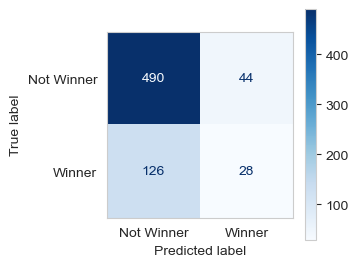

In [281]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

ada = AdaBoostClassifier(random_state=123)
ada.fit(X_train, y_train)
ada_preds = ada.predict(X_test)
print("Mean Error Rate is: ", str(mean(ada_preds != y_test)), "\n")
print("The F1 Score is: ", f1_score(y_test, ada_preds), "\n")
cm_display_ada = ConfusionMatrixDisplay.from_predictions(y_test, ada_preds, display_labels=['Not Winner', 'Winner'], cmap='Blues', ax=cm_ax)
plt.grid(None)

## Results

As part of our predictions, we'll have to scale our test set for KNN

In [282]:
# Scale the prediction data for KNN
scaler_pred = StandardScaler()
scaler_pred.fit(senate_candidates_2022_test_set)
scaled_pred_features = scaler_pred.transform(senate_candidates_2022_test_set)
knn_df_pred_feat = pd.DataFrame(scaled_pred_features,columns=senate_candidates_2022_test_set.columns)

knn_df_pred_feat.head()


number_of_supporting_parties  is_candidate_democrat  \
0                     -0.172774               1.748949   
1                     -0.172774              -0.571772   
2                     -0.172774              -0.571772   
3                     -0.172774               1.748949   
4                     -0.172774              -0.571772   

   is_candidate_republican  is_candidate_other  \
0                -0.605257           -0.971423   
1                 1.652189           -0.971423   
2                -0.605257            1.029418   
3                -0.605257           -0.971423   
4                 1.652189           -0.971423   

   total_unemployed_percentage_of_labor_force  is_current_president_democrat  \
0                                         0.0                            0.0   
1                                         0.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         0.0                            0.0   

   is_current_president_republican  region_Midwest  region_Northeast  \
0                              0.0       -0.594089         -0.387298   
1                              0.0       -0.594089         -0.387298   
2                              0.0       -0.594089         -0.387298   
3                              0.0       -0.594089         -0.387298   
4                              0.0       -0.594089         -0.387298   

   region_South  region_West  white_population_proportion  \
0      1.486372    -0.650139                 1.110223e-16   
1      1.486372    -0.650139                 1.110223e-16   
2      1.486372    -0.650139                 1.110223e-16   
3     -0.672779     1.538133                 1.110223e-16   
4     -0.672779     1.538133                 1.110223e-16   

   non_white_population_proportion  elementary_0_to_4_years  \
0                              0.0             1.734723e-18   
1                              0.0             1.734723e-18   
2                              0.0             1.734723e-18   
3                              0.0             1.734723e-18   
4                              0.0             1.734723e-18   

   elementary_5_to_8_years  highschool_1_to_3_years  highschool_4_years  \
0                      0.0                      0.0                 0.0   
1                      0.0                      0.0                 0.0   
2                      0.0                      0.0                 0.0   
3                      0.0                      0.0                 0.0   
4                      0.0                      0.0                 0.0   

   college_1_to_3_years  college_4_or_more_years  
0                   0.0                      0.0  
1                   0.0                      0.0  
2                   0.0                      0.0  
3                   0.0                      0.0  
4                   0.0                      0.0

In [283]:
logistic_midterms_pred = logistic_model.predict(senate_candidates_2022_test_set)
dt_midterms_pred = dt.predict(senate_candidates_2022_test_set)
rf_midterms_pred = rf.predict(senate_candidates_2022_test_set)
knn_midterms_pred = knn.predict(knn_df_pred_feat.values)
knn_grid_midterms_pred = knn_grid.predict(knn_df_pred_feat.values)
boosting_midterms_pred = ada.predict(senate_candidates_2022_test_set)

predicted_results = pd.DataFrame({'Candidate': candidates_2022, 'State': state_2022, 'Logistic': logistic_midterms_pred, 'Decision Trees': dt_midterms_pred, 'Random Forest': rf_midterms_pred, 'KNN': knn_midterms_pred, 'KNN - Grid Search': knn_grid_midterms_pred, 'AdaBoost': boosting_midterms_pred, '538 Predicted Winner': predicted_winner_2022})
predicted_results['Sum of Predictions'] = predicted_results['Logistic'] + predicted_results['Decision Trees'] + predicted_results['Random Forest'] + predicted_results['KNN'] + predicted_results['KNN - Grid Search'] + predicted_results['AdaBoost']
predicted_results.sort_values(by=['Sum of Predictions'], inplace=True, ascending=False)
pd.set_option('display.max_rows', None)

predicted_results.head()

Candidate          State  Logistic  Decision Trees  \
80        Maggie Hassan  NEW HAMPSHIRE         1               1   
83        Chuck Schumer       NEW YORK         1               1   
25   Richard Blumenthal    CONNECTICUT         1               1   
127         Peter Welch        VERMONT         1               1   
110      John Fetterman   PENNSYLVANIA         1               1   

     Random Forest  KNN  KNN - Grid Search  AdaBoost  538 Predicted Winner  \
80               1    0                  1         1                     1   
83               1    0                  1         1                     1   
25               1    0                  1         1                     1   
127              1    0                  1         1                     1   
110              1    0                  1         1                     0   

     Sum of Predictions  
80                    5  
83                    5  
25                    5  
127                   5  
110                   5

In [284]:
logistic_missclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == logistic_midterms_pred)) / len(predicted_winner_2022)
dt_misclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == dt_midterms_pred)) / len(predicted_winner_2022)
rf_misclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == rf_midterms_pred)) / len(predicted_winner_2022)
knn_misclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == knn_midterms_pred)) / len(predicted_winner_2022)
knn_grid_misclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == knn_grid_midterms_pred)) / len(predicted_winner_2022)
boosting_misclassified = (len(predicted_winner_2022) - sum(predicted_winner_2022 == boosting_midterms_pred)) / len(predicted_winner_2022)


In [285]:
model_names = ['Logistic', 'Decision Trees', 'Random Forest', 'KNN', 'KNN - Grid Search', 'AdaBoost']
mean_error_rates = [logistic_missclassified, dt_misclassified, rf_misclassified, knn_misclassified, knn_grid_misclassified, boosting_misclassified]

model_error_rates = list(zip(model_names, mean_error_rates))

mean_error_rates_df = pd.DataFrame(model_error_rates, columns = ['Model Name', 'Mean Error Rate'])

mean_error_rates_df = mean_error_rates_df.sort_values('Mean Error Rate', ascending=True).reset_index(drop=True)

mean_error_rates_df


Model Name  Mean Error Rate
0  KNN - Grid Search         0.210145
1           AdaBoost         0.239130
2     Decision Trees         0.246377
3           Logistic         0.275362
4                KNN         0.275362
5      Random Forest         0.311594

## Evaluation against 538 and Actual Results

Below is the code that evaluates our best results (KNN Grid Search) against the 538 Predictions and the actual midterm election results 

In [286]:
senate_winners_2022_results = senate_winners_2022[['candidate', 'state', 'is_predicted_winner_538', 'is_actual_winner']]

best_predictions = predicted_results[['Candidate', 'State', 'KNN - Grid Search']]

best_predictions = best_predictions.rename(mapper={'Candidate':'candidate', 'State':'state', 'KNN - Grid Search': 'predicted_winner'}, axis='columns')

evaluation = senate_winners_2022_results.merge(best_predictions, on='candidate', how='inner')

evaluation.rename(mapper={'state_x':'state'}, axis='columns', inplace=True)

evaluation.drop('state_y', axis='columns', inplace=True)

evaluation.head()

candidate    state  is_predicted_winner_538  is_actual_winner  \
0         Will Boyd  ALABAMA                        0                 0   
1       Katie Britt  ALABAMA                        1                 1   
2   John Sophocleus  ALABAMA                        0                 0   
3  Patricia Chesbro   ALASKA                        0                 0   
4       Buzz Kelley   ALASKA                        0                 0   

   predicted_winner  
0                 0  
1                 1  
2                 0  
3                 0  
4                 1

In [287]:
evaluation['predicted_correctly_vs_538'] = evaluation['is_predicted_winner_538'] == evaluation['predicted_winner']
evaluation['actual_vs_538'] = evaluation['is_predicted_winner_538'] == evaluation['is_actual_winner']
evaluation['predicted_correctly_vs_actual_winner'] = evaluation['is_actual_winner'] == evaluation['predicted_winner']

evaluation.head()

candidate    state  is_predicted_winner_538  is_actual_winner  \
0         Will Boyd  ALABAMA                        0                 0   
1       Katie Britt  ALABAMA                        1                 1   
2   John Sophocleus  ALABAMA                        0                 0   
3  Patricia Chesbro   ALASKA                        0                 0   
4       Buzz Kelley   ALASKA                        0                 0   

   predicted_winner  predicted_correctly_vs_538  actual_vs_538  \
0                 0                        True           True   
1                 1                        True           True   
2                 0                        True           True   
3                 0                        True           True   
4                 1                       False           True   

   predicted_correctly_vs_actual_winner  
0                                  True  
1                                  True  
2                                  True  
3                                  True  
4                                 False

Mean Error Rate is:  0.21014492753623187 

The F1 Score is:  0.49122807017543857 



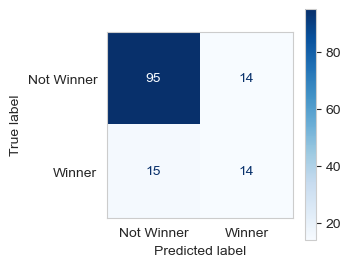

In [183]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))

evaluation['is_actual_winner'] = np.where(evaluation['is_actual_winner']==1, True, False)
evaluation['predicted_winner'] = np.where(evaluation['predicted_winner']==1, True, False)

print("Mean Error Rate is: ", str(mean(evaluation['predicted_winner'] != evaluation['is_actual_winner'])), "\n")
print("The F1 Score is: ", f1_score(evaluation['predicted_winner'], evaluation['is_actual_winner']), "\n")

cm_evaluation_actual = ConfusionMatrixDisplay.from_predictions(
    evaluation['is_actual_winner'], 
    evaluation['predicted_winner'],
    display_labels=['Not Winner', 'Winner'],
    cmap='Blues',
    ax=cm_ax)
plt.grid(None)

Mean Error Rate is:  0.21014492753623187 

The F1 Score is:  0.5245901639344263 



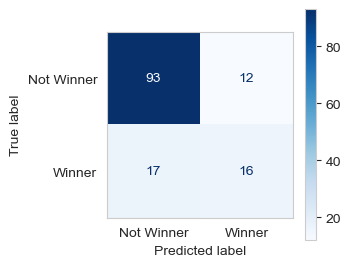

In [185]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))
evaluation['is_predicted_winner_538'] = np.where(evaluation['is_predicted_winner_538']==1, True, False)
evaluation['predicted_winner'] = np.where(evaluation['predicted_winner']==1, True, False)

print("Mean Error Rate is: ", str(mean(evaluation['predicted_winner'] != evaluation['is_predicted_winner_538'])), "\n")
print("The F1 Score is: ", f1_score(evaluation['predicted_winner'], evaluation['is_predicted_winner_538']), "\n")

cm_evaluation_actual = ConfusionMatrixDisplay.from_predictions(
    evaluation['is_predicted_winner_538'],
    evaluation['predicted_winner'],
    display_labels=['Not Winner', 'Winner'],
    cmap='Blues',
    ax=cm_ax)
plt.grid(None)

Mean Error Rate is:  0.043478260869565216 

The F1 Score is:  0.9032258064516129 



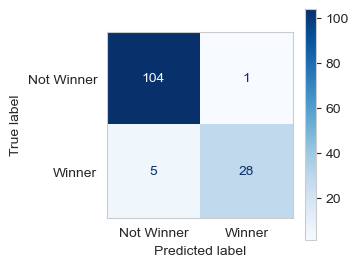

In [186]:
f,cm_ax = plt.subplots(1,1,figsize=(3,3))
print("Mean Error Rate is: ", str(mean(evaluation['is_actual_winner'] != evaluation['is_predicted_winner_538'])), "\n")
print("The F1 Score is: ", f1_score(evaluation['is_actual_winner'], evaluation['is_predicted_winner_538']), "\n")

cm_evaluation_actual = ConfusionMatrixDisplay.from_predictions(
    evaluation['is_predicted_winner_538'],
    evaluation['is_actual_winner'],
    display_labels=['Not Winner', 'Winner'],
    cmap='Blues',
    ax=cm_ax)
plt.grid(None)

## Conclusions

## Appendix

In [161]:
profile = ProfileReport(training_data, title="Pandas Profiling Report")

In [289]:
# profile.to_notebook_iframe()